# Load Images

## Import and preview hrHSI

In [1]:
from preprocessing import preprocessHrHSI

# Specify paths
hr_path = "data/FX10/"
hr_mtx_path = 'data/FX10/2D/hrHSI_matrix.npy'
hr_dist_path = 'data/FX10/2D/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + "leaf_test1.hdf5", hr_mtx_path, hr_dist_path)

# Store to variables
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

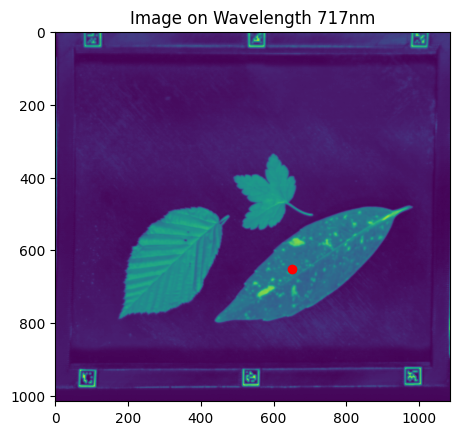

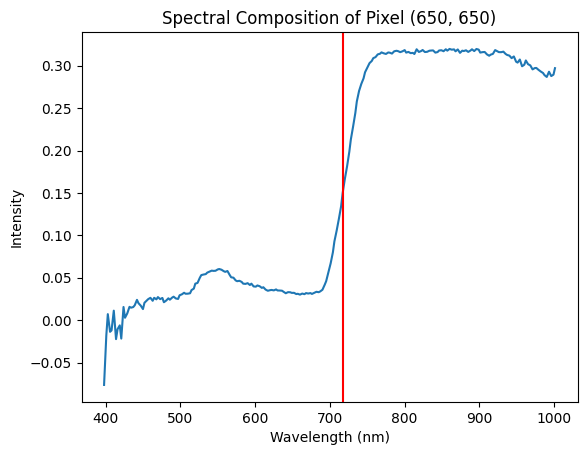

In [2]:
from preprocessing import previewHrHSI

# Select pixel and spectrum to highlight
hr_selected_pixel = (650, 650)
hr_selected_spectrum = 120

# Preview
previewHrHSI(hr_img, hr_wavelengths, hr_selected_pixel, hr_selected_spectrum)

## Import and preview snapshot

In [3]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/leaf_test_processed/leaf_test/"
ss_mtx_path = 'data/Snapshot/2D/snapshot_matrix.npy'
ss_dist_path = 'data/Snapshot/2D/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)

# Store to variables
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

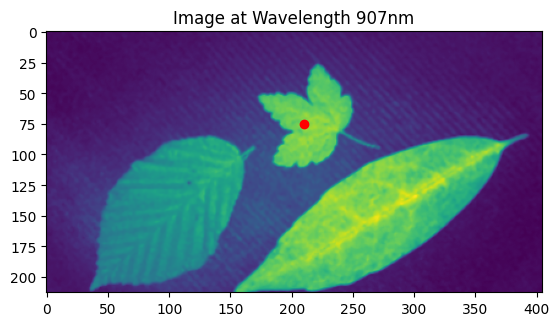

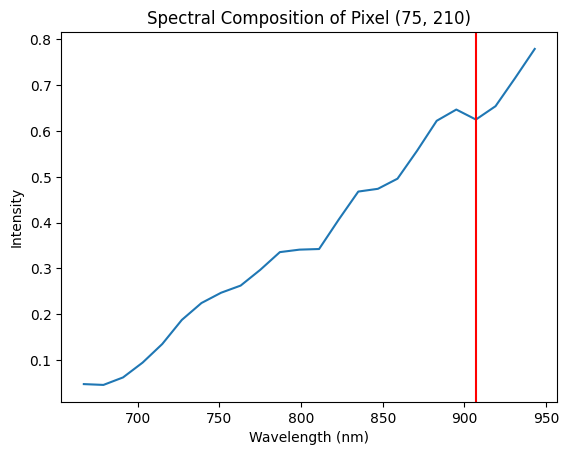

In [4]:
from preprocessing import previewSnapshot

# Select pixel and spectrum to highlight
ss_selected_pixel = (75, 210)
ss_selected_spectrum = 20

# Preview
previewSnapshot(ss_img, ss_wavelengths, ss_selected_pixel, ss_selected_spectrum)

## Compare hrHSI and Snapshot

In [9]:
from preprocessing import preprocessHrHSI

# Specify paths
# hr_path = "data/FX10/calibration0"
hr_path = "data/FX10/spelt1"
hr_mtx_path = 'data/FX10/2D/hrHSI_matrix.npy'
hr_dist_path = 'data/FX10/2D/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + ".hdf5", hr_mtx_path, hr_dist_path)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [114]:
from preprocessing import preprocessSnapshot

# Specify paths
# ss_path = "data/Snapshot/calibration_processed/calibration0/"
ss_path = "data/Snapshot/spelt_processed/spelt1/"
ss_mtx_path = 'data/Snapshot/2D/snapshot_matrix.npy'
ss_dist_path = 'data/Snapshot/2D/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

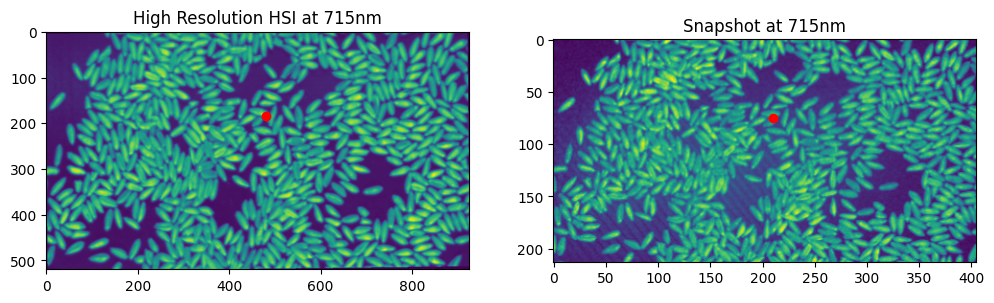

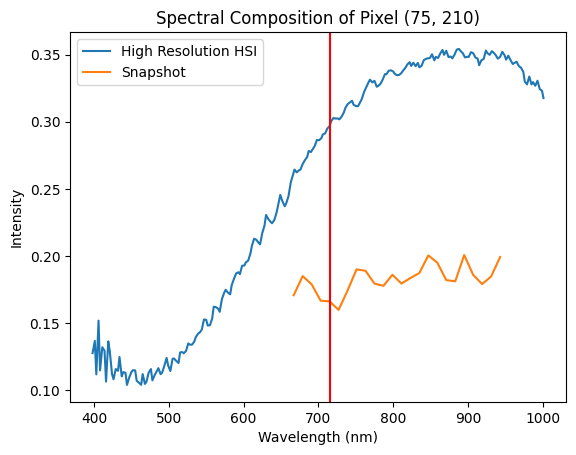

In [115]:
from align_images import align_images, plot_image_comparison

# Set offsets
x_off = (70, 995)   # Full: (0, 1084)
y_off = (200, 720)   # Full: (0, 1015)

# Align images
hr_img_al, ss_img_al = align_images(hr_img=hr_img,
                                    ss_img=ss_img, 
                                    x_off=x_off, 
                                    y_off=y_off,
                                    hr_rot=0.7,
                                    ss_rot=0)

# Plot image comparison
plot_image_comparison(hr_img=hr_img_al, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img_al, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(75, 210),
                      selected_spectrum=715)

In [116]:
# Compare resolutions
print("HrHSI:", hr_img_al.shape)
print("Shapshot:", ss_img_al.shape)
print("\n")

# Compare aspect ratio
print("HrHSI:", round(hr_img_al.shape[1] / hr_img_al.shape[0], 2))
print("Shapshot:", round(ss_img_al.shape[1] / ss_img_al.shape[0], 2))

HrHSI: (520, 925, 224)
Shapshot: (213, 405, 24)


HrHSI: 1.78
Shapshot: 1.9


## Select the 24 wavelengths present in the snapshot

In [117]:
import numpy as np

# Get indexes of hr_wavelengths that are present in ss_wavelengths (if no exact match, get closest)
hr_wavelengths_idx = []
for i in range(len(ss_wavelengths)):
    idx = (np.abs(np.array(hr_wavelengths) - np.array(ss_wavelengths[i]))).argmin()
    hr_wavelengths_idx.append(idx)

print(hr_wavelengths_idx)

# Filter hr_wavelenghts by index hr_wavelegths_idx
hr_wavelengths_filtered = [hr_wavelengths[i] for i in hr_wavelengths_idx]

print(hr_wavelengths_filtered)

[101, 106, 110, 115, 119, 123, 128, 132, 137, 141, 145, 150, 154, 158, 163, 167, 172, 176, 180, 185, 189, 193, 198, 202]
[666, 679, 690, 704, 715, 726, 739, 750, 764, 775, 786, 800, 811, 822, 835, 846, 860, 871, 882, 896, 907, 918, 932, 943]


In [70]:
hr_img_al_shp = hr_img_al[:, :, hr_wavelengths_idx]
hr_img_al_shp.shape

(520, 925, 24)

# Explore processed files

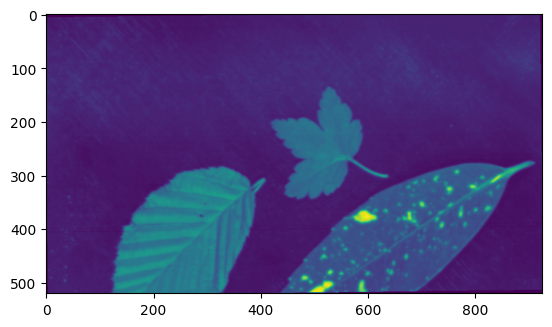

In [109]:
# Read numpy file
import numpy as np
hr_img_2 = np.load('data/Processed/leaf_test1_s.npy')

# Plot image
import matplotlib.pyplot as plt
plt.imshow(hr_img_2[:, :, 3])
plt.show()

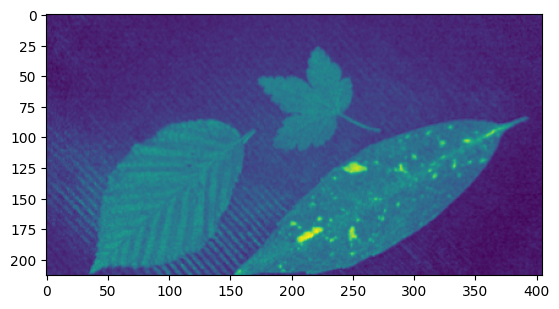

In [110]:
plt.imshow(ss_img[:, :, 3])
plt.show()